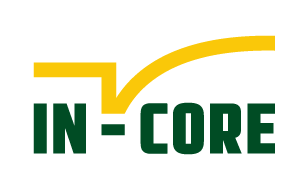


# Tower Damage

**Jupyter Notebook Created by**:
   - Mehrzad Rahimi, Postdoctoral fellow at Rice University (mr77@rice.edu)
   - Jamie E. Padgett, Professor at Rice University (jamie.padgett@rice.edu)

## 1) Initialization

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import geopandas as gpd 
import numpy as np
import sys 
import os 
import glob
import matplotlib.pyplot as plt
import contextily as ctx
import copy
import math
from scipy.stats import norm
from pathlib import Path

from pyincore import IncoreClient, Dataset, DataService, HazardService, FragilityService, MappingSet, FragilityCurveSet
from pyincore_viz.geoutil import GeoUtil as geoviz
from pyincore_viz.plotutil import PlotUtil as plotviz

# importing pyIncone analyses:
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.bridgedamage import BridgeDamage
from pyincore.analyses.roaddamage import RoadDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.housingunitallocation import HousingUnitAllocation
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential

In [2]:
# Check package versions - good practice for replication
print("Python Version ", sys.version)
print("pandas version: ", pd.__version__)
print("numpy version: ", np.__version__)

Python Version  3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:41:22) [MSC v.1929 64 bit (AMD64)]
pandas version:  1.5.2
numpy version:  1.24.1


In [3]:
# Check working directory - good practice for relative path access
os.getcwd()

'C:\\Users\\nathanael99\\MyProjects\\IN-CORE\\IN-CORE_Galveston\\jupyter_book\\notebooks\\01_Damage_Electric Power_Towers'

In [4]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
#client.clear_cache() 
data_service = DataService(client) # create data_service object for loading files
hazard_service = HazardService(client)
fragility_service = FragilityService(client)

StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

## 2) Setting up an alternative plotting function to plot spatially

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_gdf_map(gdf, column, category=False, basemap=True, source=ctx.providers.OpenStreetMap.Mapnik, **kwargs):
    """
    Taken from pyincore-viz. 
    Not using the pyincore-viz version b/c it's limited on plotting options
        - Added **kwargs for more control over the geopandas plotting function
    """
    fig, ax = plt.subplots(1,1, figsize=(10,15))
    gdf = gdf.to_crs(epsg=3857)

    if category == False: # adding a colorbar to side
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)

        ax = gdf.plot(figsize=(10, 10), 
                      column=column,
                      categorical=category, 
                      legend=True,
                      ax=ax,
                      cax=cax,
                     **kwargs)

    elif category == True:
        ax = gdf.plot(figsize=(10, 10), 
                      column=column,
                      categorical=category, 
                      legend=True,
                      ax=ax,
                     **kwargs)

        
    if basemap:
        ctx.add_basemap(ax, source=source)

import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

## 3) Hazard Model (Hurricane)

In [6]:
hazard_type = "hurricane"

There are currently five hurricane hazard data for Galveston testbed. Four of them were created using the dynamically coupled versions of the Advanced Circulation (ADCIRC) and Simulating Waves Nearshore (SWAN) models. One of them is a surrogate model developed using USACE datasets.

| No. | Simulation type | Name | GUID | More details |
| --- | --- | --- | --- | --- |
| 1 | Coupled ADCIRC+SWAN | Hurricane Ike Hindcast | <font color='red'>5fa5a228b6429615aeea4410 </font> | Darestani et al. (2021) |
| 2 | Coupled ADCIRC+SWAN | 2% AEP Hurricane Simulation | <font color='red'>5fa5a83c7e5cdf51ebf1adae </font> | Darestani et al. (2021) |
| 3 | Coupled ADCIRC+SWAN | 1% AEP Hurricane Simulation | <font color='red'>5fa5a9497e5cdf51ebf1add2 </font> | Darestani et al. (2021) |
| 4 | Coupled ADCIRC+SWAN | 0.2% AEP Hurricane Simulation | <font color='red'>5fa5aa19b6429615aeea4476 </font> | Darestani et al. (2021) |
| 5 | Kriging-based surrogate model | Galveston Deterministic Hurricane - Kriging | <font color='red'>5f15cd627db08c2ccc4e3bab </font> | Fereshtehnejad et al. (2021) |


### Coupled ADCIRC+SWAN
Galveston Island was struck by Hurricane Ike in September, 2008, with maximum windspeeds of 49 m/s (95 kts) and storm surge elevations reaching at least +3.5 m (NAVD88) on Galveston Island. A full hindcast of Hurricane Ike’s water levels, and wave conditions along with 2% (50-yr return period), 1% (100-yr return period), and 0.2% (500-yr return period) Annual Exceedance Probabilities (AEP) hurricane simulations were created using ADCIRC+SWAN models. These hurricane hazard events contain **eight hazardDatasets**, which is five more than the current pyincore hurricane schema. Please be sure to adjust your codes accordingly if you need to incorporate the five new intensity measures (IMs). The existing schema includes the peak significant wave height, peak surge level, and inundation duration. These new events include those as well as maximum inundation depth, peak wave period, wave direction, maximum current speed, and maximum wind speed. 

### Kriging-based surrogate model
**Three hazardDatasets** of kriging-based surrogate models are developed for peak significant wave height, peak surge level, and inundation duration. Training datasets for developing the Kriging surorgate models were collected through USACE. For the peak significant wave height, peak surge level, and inundation duration the training datasets included 61, 251, and 254 synthetic storms, respectively. 

### What is the your desired hurricane simulation?

In [94]:
hur_hazard_dict = {1: "Towers_Ike.csv", 
                   2: "Towers_50yr.csv",
                   3: "Towers_100yr.csv",
                   4: "Towers_500yr.csv",
                   5: "Towers_kriging.csv"}
hur_no = int(input('The No. of your desired hurricane simulation: '))

The No. of your desired hurricane simulation: 1


In [95]:
EPN_inv_csv = hur_hazard_dict[hur_no]
EPN_inv_csv

'Towers_Ike.csv'

In [96]:
path_to_output = os.path.join(os.getcwd(), 'output', 'Results for Hurricane No{}' .format(hur_no))
if not os.path.exists(path_to_output):
    os.makedirs(path_to_output)

In [97]:
result_name = os.path.join(path_to_output, 'Galv_EPN_towers_result_hurNo{}' .format(hur_no))

# 4) Towers inventory, fragility, and damage

## INVENTORY

In [98]:
# Wood Poles Inventory Dataset
EPN_inv_df  = pd.read_csv(EPN_inv_csv)

Lon_EPNnodes = pd.read_csv(EPN_inv_csv, usecols=['LON'])
Lat_EPNnodes = pd.read_csv(EPN_inv_csv, usecols=['LAT'])

WindVel = pd.read_csv(EPN_inv_csv, usecols=['MaxWindVel']) 
WaterVel = pd.read_csv(EPN_inv_csv, usecols=['MaxWaterVel']) 
SurgeHeight = pd.read_csv(EPN_inv_csv, usecols=['MaxWSE']) 
WaveHeight = pd.read_csv(EPN_inv_csv, usecols=['MaxSigWaveHt']) 
WindDir = pd.read_csv(EPN_inv_csv, usecols=['MaxWaveDir']) 

Type = pd.read_csv(EPN_inv_csv, usecols=['TYPE']) 
SpanLength = pd.read_csv(EPN_inv_csv, usecols=['SpanLength']) 

In [99]:
def tower_collapse(WindVel,WindDir):

    WindVel=np.array(WindVel)
    WindDir=np.array(WindDir)
    
    pf_tower=[];
    
    for i in range(0, np.size(WindVel,0)):
        
        pf_tower.append(1-(1-(1/(1+math.exp(-(-12.1615+0.0860*WindVel[i,0]*2.2369*math.cos(WindDir[i,0]*math.pi/180))))))
                   *(1-(1/(1+math.exp(-(-9.9818+0.0554*WindVel[i,0]*2.2369*math.sin(WindDir[i,0]*math.pi/180)))))))
        
    return pf_tower

In [100]:
PF_towercollapse = tower_collapse(WindVel,WindDir)

In [101]:
PF_towercollapse_df = pd.DataFrame({'Pf_TOWER':PF_towercollapse})

In [102]:
Galv_Towers_df = gpd.read_file('Galv_Towers.shp')
Galv_Towers_df = Galv_Towers_df.to_crs(epsg=3857)

In [103]:
EPN_tower_PF_df_final = pd.merge(Galv_Towers_df, PF_towercollapse_df, left_index=True, right_index=True)
EPN_tower_PF_df_final

,OBJECTID,LON,LAT,CLASS,HEIGHT,TYPE,SpanLength,geometry,Pf_TOWER
0,10446,-94.870458,29.289268,None,None,3,146.029603,POINT (-10560931.099 3412515.125),0.000945
1,10447,-94.871713,29.289987,None,None,3,145.692017,POINT (-10561070.803 3412606.893),0.000931
2,10448,-94.873065,29.290649,None,None,3,154.658730,POINT (-10561221.232 3412691.355),0.000931
3,10449,-94.874481,29.291192,None,None,3,158.459319,POINT (-10561378.891 3412760.721),0.001087
4,10450,-94.875901,29.291737,None,None,3,154.382648,POINT (-10561536.943 3412830.324),0.001759
...,...,...,...,...,...,...,...,...,...
76,12555,-94.824458,29.296551,None,None,3,131.901940,POINT (-10555810.346 3413444.717),0.001217
77,13763,-94.865847,29.287896,None,None,3,229.439305,POINT (-10560417.785 3412339.968),0.000011
78,13764,-94.865891,29.288025,None,None,3,97.145985,POINT (-10560422.658 3412356.475),0.000011
79,16036,-94.852163,29.289548,None,None,3,0.000000,POINT (-10558894.518 3412550.885),0.000796


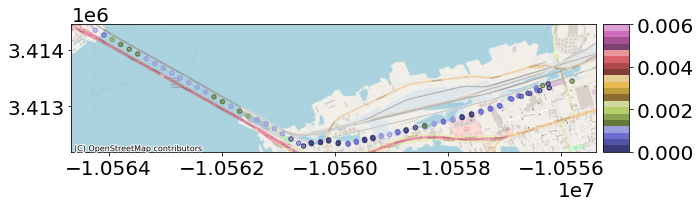

In [104]:
plot_gdf_map(EPN_tower_PF_df_final, column='Pf_TOWER', vmin=0, vmax=0.006, cmap='tab20b', linewidth=4, markersize = 2)

In [105]:
maxpf = [PF_towercollapse_df.max()]
maxpf

[Pf_TOWER    0.001759
 dtype: float64]

In [106]:
EPN_tower_PF_df_final.to_csv(result_name+'.csv')